In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Activation, merge
from keras.layers import Flatten, Dropout, Dense
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
import keras.backend as K
from keras.utils.np_utils import to_categorical
from scipy.ndimage.interpolation import rotate, shift

Using TensorFlow backend.


In [2]:
def random_jitter(cpy):
    if np.random.random() > .5:
        cpy = shift(cpy, shift=(np.random.randint(-2,2,3)))
    if np.random.random() > .5:
        cpy = rotate(cpy, angle = np.random.randint(-15,15,1), reshape=False)
    if np.random.random() > .5:
        cpy = np.fliplr(cpy)
    return cpy

In [3]:
def resizeAndCrop(img, size):
    h,w = img.shape[:2]
    tw, th = size
    
    if h/w > th/tw :
        r = tw / w
        dim = (tw, int(h * r))
    else:
        r = th / h
        dim = (int(w * r), th)
    
    resized = cv2.resize(img, dim)
    
#     crop if oversize
    rh, rw = resized.shape[:2]
    print (rh, rw)
    h_diff = rh-th
    w_diff = rw-tw
    newslice_rh_i = int(h_diff/2)
    newslice_rh_e = int(rh-h_diff/2)
    newslice_rw_i = int(w_diff/2)
    newslice_rw_e = int(rw-w_diff/2)
    print(newslice_rw_i, newslice_rw_e, newslice_rh_i, newslice_rh_e)
#     cropped = resized[0:tw, 0:th]
    cropped = resized[newslice_rh_i:newslice_rh_e, newslice_rw_i:newslice_rw_e]
    return cropped

In [4]:
X_train = []
x_label = []
X_test = []
x_test_label = []

IMAGE_WIDTH = 80
IMAGE_HEIGHT = 60

for img_class, directory in enumerate(['new_imgs/red', 'new_imgs/yellow', 'new_imgs/green']):
    for i, file_name in enumerate(glob.glob("{}/*.*".format(directory))):
        file = cv2.imread(file_name)
        file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
#         resized = resizeAndCrop(file, (IMAGE_WIDTH,IMAGE_HEIGHT))
        resized = cv2.resize(file, (IMAGE_WIDTH, IMAGE_HEIGHT))
#         print(file_name)
#         plt.figure(figsize=(2,2))
#         plt.imshow(resized)
#         plt.show()

        X_train.append(resized/255.)
        x_label.append(img_class)
        
print(np.array(x_label).shape)
print(np.array(X_train).shape)

(913,)
(913, 60, 80, 3)


In [5]:
X_train_copy = np.copy(np.array(X_train))
x_label_copy = np.copy(np.array(x_label))

X_train_jittered = [];
x_label_jittered = [];


def jitter_dataset(image_data):
#     jittered_images = []
    for i, img in enumerate(image_data):
        jittered_image = random_jitter(img)
        X_train_jittered.append(jittered_image)
        x_label_jittered.append(x_label_copy[i])
        

jitter_dataset(X_train_copy)
jitter_dataset(X_train_copy)
jitter_dataset(X_train_copy)

X_train_jittered = np.array(X_train_jittered)
x_label_jittered = np.array(x_label_jittered)

X_train_extra = np.concatenate((X_train_copy, X_train_jittered), axis=0)
print(X_train_extra.shape)

x_label_extra = np.concatenate((x_label_copy, x_label_jittered), axis=0)
print(x_label_extra.shape)

(3652, 60, 80, 3)
(3652,)


In [6]:
X_train = np.array(X_train)
x_label = np.array(x_label)

for img_class, directory in enumerate(['test/red', 'test/yellow', 'test/green']):
    for i, file_name in enumerate(glob.glob("{}/*.*".format(directory))):
        file = cv2.imread(file_name)

        file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
#         resized = resizeAndCrop(file, (IMAGE_WIDTH,IMAGE_HEIGHT))
        resized = cv2.resize(file, (IMAGE_WIDTH, IMAGE_HEIGHT))
        X_test.append(resized/255.)
        x_test_label.append(img_class)
        
X_test = np.array(X_test)
x_test_label = np.array(x_test_label)

In [7]:
nb_classes = 3
image_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3]
print(image_shape)

[60, 80, 3]


In [8]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=image_shape, activation='relu'))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
categorical_labels = to_categorical(x_label_extra)
categorical_test_labels = to_categorical(x_test_label)


In [53]:
score = model.evaluate(X_train_extra, categorical_labels, verbose=0)
print(model.metrics_names)
print (score)

['loss', 'acc']
[0.066627278756672945, 0.97918948521358162]


22/22 [==============================] - 0s


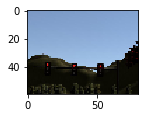

0 [ 0.31669506  0.35008138  0.33322352] [ 1.  0.  0.]
1 0


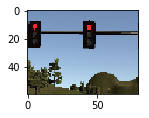

1 [ 0.32411599  0.34970629  0.32617766] [ 1.  0.  0.]
1 0


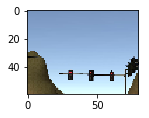

2 [ 0.3181639   0.3445839   0.33725229] [ 1.  0.  0.]
1 0


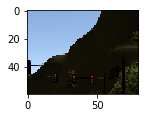

3 [ 0.3254244   0.33916155  0.33541408] [ 1.  0.  0.]
1 0


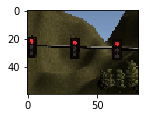

4 [ 0.3264654   0.34146923  0.33206537] [ 1.  0.  0.]
1 0


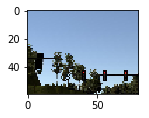

5 [ 0.32078549  0.35197318  0.32724127] [ 1.  0.  0.]
1 0


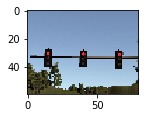

6 [ 0.32159603  0.35460541  0.3237986 ] [ 1.  0.  0.]
1 0


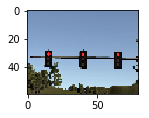

7 [ 0.32057613  0.35892817  0.32049567] [ 1.  0.  0.]
1 0


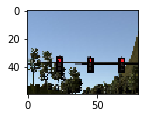

8 [ 0.31766835  0.35484859  0.32748312] [ 1.  0.  0.]
1 0


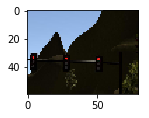

9 [ 0.32584646  0.3349345   0.33921903] [ 1.  0.  0.]
2 0


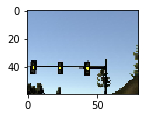

10 [ 0.32126471  0.34256816  0.33616704] [ 0.  1.  0.]
1 1


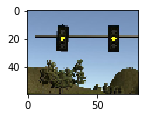

11 [ 0.31875157  0.35746747  0.32378092] [ 0.  1.  0.]
1 1


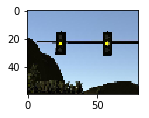

12 [ 0.3221859   0.3575834   0.32023072] [ 0.  1.  0.]
1 1


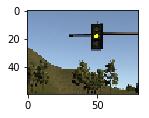

13 [ 0.31189945  0.34357828  0.34452224] [ 0.  1.  0.]
2 1


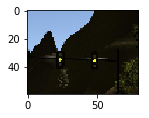

14 [ 0.32916293  0.33666506  0.33417204] [ 0.  1.  0.]
1 1


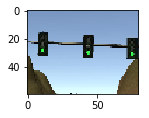

15 [ 0.32054815  0.34694394  0.33250782] [ 0.  0.  1.]
1 2


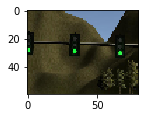

16 [ 0.32549891  0.3435345   0.33096659] [ 0.  0.  1.]
1 2


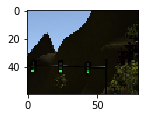

17 [ 0.32728076  0.33497834  0.33774084] [ 0.  0.  1.]
2 2


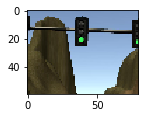

18 [ 0.32371819  0.33779112  0.33849069] [ 0.  0.  1.]
2 2


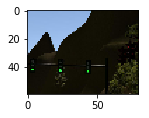

19 [ 0.32719103  0.33617699  0.33663195] [ 0.  0.  1.]
2 2


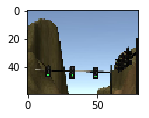

20 [ 0.32034305  0.3461045   0.33355251] [ 0.  0.  1.]
1 2


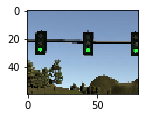

21 [ 0.32173437  0.34910971  0.32915589] [ 0.  0.  1.]
1 2
0.3181818181818182


In [11]:
prediction = model.predict(X_test, verbose=1)
num_correct = 0
for i in range(len(prediction)):
    file = X_test[i]
    plt.figure(figsize=(2,2))
    plt.imshow(file)
    plt.show()
    print (i, prediction[i], categorical_test_labels[i])
    prediction_val = np.argmax(prediction[i])
    actual_val = np.argmax(categorical_test_labels[i])
    print(prediction_val, actual_val)
    if prediction_val == actual_val:
        num_correct +=1
print(num_correct/len(prediction))

In [55]:
model.save('sim-classifier-8.h5')